In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
from models.lr_finder import LRFinder

/home/paperspace/anaconda3/envs/fontastic/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from fastai.vision import transform as tfm

### Creating image datasets an data loaders for train and test using the experiments folder split

In [3]:
experiments_path = '/home/paperspace/code/fontastic/data/stratified/'
data_path = '/home/paperspace/code/fontastic/data/dst/training/'

In [4]:
train_rand_tfms = tfm.get_transforms(do_flip=False)
test_rand_tfms = tfm.get_transforms(do_flip=False)

In [5]:
data_transforms = {
    'train': transforms.Compose([

        transforms.RandomAffine(degrees=5, fillcolor=(255, 255, 255)),
        transforms.ColorJitter(brightness=(1, 1.2), contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([

        transforms.RandomAffine(degrees=5, fillcolor=(255, 255, 255)),
        transforms.ColorJitter(brightness=(0.8, 1.2), contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [26]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [127]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)
    

In [128]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [129]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [ ]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

In [ ]:
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [7]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 999
     Root Location: /home/paperspace/code/fontastic/data/stratified/train
     Transforms (if any): Compose(
                              RandomAffine(degrees=(-5, 5), fillcolor=(255, 255, 255))
                              ColorJitter(brightness=(1, 1.2), contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'test': Dataset ImageFolder
     Number of datapoints: 250
     Root Location: /home/paperspace/code/fontastic/data/stratified/test
     Transforms (if any): Compose(
                              RandomAffine(degrees=(-5, 5), fillcolor=(255, 255, 255))
                              ColorJitter(brightness=(0.8, 1.2), contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                              ToTens

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=32, 
                                             shuffle=True, 
                                             num_workers=3) 
               for x in ['train', 'test']}

In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f66c2210198>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f66c2210278>}

In [10]:
class_names = image_datasets['train'].classes

In [11]:
class_names

['Fahkwang', 'Lato', 'Lobster', 'Lora', 'MajorMonoDisplay', 'Merriweather']

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda', index=0)

In [14]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


### Visualizing images

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [16]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [18]:
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
#                 scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [19]:
import ssl


In [20]:
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
model_ft = models.resnet50(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-03, weight_decay=1e-02)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-7, weight_decay=1e-2)
lrf = LRFinder(model_ft, optimizer, criterion, device="cuda")
lrf.range_test(dataloaders['train'], end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


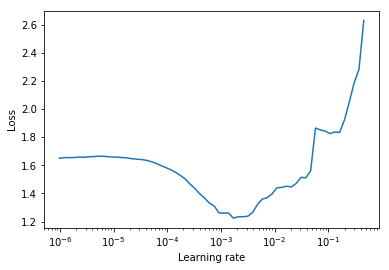

In [23]:
lrf.plot()

In [24]:
lrf.reset()

In [26]:
model_ft = models.resnet50(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-03, weight_decay=1e-02)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=40)

Epoch 0/39
----------
train Loss: 1.4014 Acc:0.4685

test Loss: 1.1405 Acc:0.5600

Epoch 1/39
----------
train Loss: 0.9521 Acc:0.6126

test Loss: 433.0719 Acc:0.3960

Epoch 2/39
----------
train Loss: 0.9702 Acc:0.6076

test Loss: 0.9965 Acc:0.6120

Epoch 3/39
----------
train Loss: 0.6786 Acc:0.7287

test Loss: 2.2418 Acc:0.3600

Epoch 4/39
----------
train Loss: 0.6702 Acc:0.7377

test Loss: 1.0157 Acc:0.5920

Epoch 5/39
----------
train Loss: 0.4778 Acc:0.8228

test Loss: 3.1915 Acc:0.1920

Epoch 6/39
----------
train Loss: 0.4408 Acc:0.8338

test Loss: 1.0038 Acc:0.4880

Epoch 7/39
----------
train Loss: 0.3621 Acc:0.8709

test Loss: 1.0677 Acc:0.5240

Epoch 8/39
----------
train Loss: 0.4261 Acc:0.8619

test Loss: 0.8439 Acc:0.7800

Epoch 9/39
----------
train Loss: 0.3863 Acc:0.8659

test Loss: 0.9458 Acc:0.5920

Epoch 10/39
----------
train Loss: 0.3277 Acc:0.8809

test Loss: 1.5174 Acc:0.4440

Epoch 11/39
----------
train Loss: 0.4954 Acc:0.8148

test Loss: 1.3809 Acc:0.4280



KeyboardInterrupt: 

In [55]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = True
    for param in list(model.parameters())[:-1]:
        param.requires_grad = False
    return model

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True
    return model
    

In [29]:
model_ft = unfreeze(model_ft)

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2056 Acc:0.9299

test Loss: 0.7248 Acc:0.7560

Epoch 1/9
----------
train Loss: 0.1585 Acc:0.9510

test Loss: 0.7665 Acc:0.7360

Epoch 2/9
----------
train Loss: 0.4671 Acc:0.8348

test Loss: 0.5958 Acc:0.7760

Epoch 3/9
----------
train Loss: 0.2925 Acc:0.9009

test Loss: 1.8298 Acc:0.5240

Epoch 4/9
----------
train Loss: 0.2961 Acc:0.8919

test Loss: 0.7023 Acc:0.7320

Epoch 5/9
----------
train Loss: 0.1882 Acc:0.9389

test Loss: 0.7925 Acc:0.7160

Epoch 6/9
----------
train Loss: 0.2375 Acc:0.9339

test Loss: 1.0633 Acc:0.6320

Epoch 7/9
----------
train Loss: 0.2460 Acc:0.9229

test Loss: 0.8348 Acc:0.7440

Epoch 8/9
----------
train Loss: 0.1633 Acc:0.9590

test Loss: 0.7900 Acc:0.7240

Epoch 9/9
----------
train Loss: 0.1624 Acc:0.9499

test Loss: 0.2069 Acc:0.9320

Training complete in 4.000000m 26s
Best val acc: 0.932000


In [56]:
model_ft = freeze(model_ft)

In [57]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4360 Acc:0.8488

test Loss: 0.6452 Acc:0.8120

Epoch 1/19
----------
train Loss: 0.6208 Acc:0.7718

test Loss: 0.6950 Acc:0.7400

Epoch 2/19
----------
train Loss: 0.6747 Acc:0.7698

test Loss: 0.6901 Acc:0.7880

Epoch 3/19
----------
train Loss: 0.7271 Acc:0.7738

test Loss: 0.8617 Acc:0.7600

Epoch 4/19
----------
train Loss: 0.8535 Acc:0.7638

test Loss: 0.9477 Acc:0.7560

Epoch 5/19
----------
train Loss: 0.9515 Acc:0.7608

test Loss: 1.0283 Acc:0.7800

Epoch 6/19
----------
train Loss: 1.0515 Acc:0.7638

test Loss: 1.1225 Acc:0.7880

Epoch 7/19
----------
train Loss: 1.1577 Acc:0.7618

test Loss: 1.1962 Acc:0.7920

Epoch 8/19
----------
train Loss: 1.2224 Acc:0.7668

test Loss: 1.2698 Acc:0.7520

Epoch 9/19
----------
train Loss: 1.2784 Acc:0.7608

test Loss: 1.3125 Acc:0.7520

Epoch 10/19
----------
train Loss: 1.3330 Acc:0.7247

test Loss: 1.3461 Acc:0.7160

Epoch 11/19
----------
train Loss: 1.3632 Acc:0.6977

test Loss: 1.3871 Acc:0.6800

Ep

In [58]:
model_ft = unfreeze(model_ft)

In [59]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2154 Acc:0.9409

test Loss: 2.7387 Acc:0.4560

Epoch 1/9
----------
train Loss: 0.2470 Acc:0.9299

test Loss: 5.0905 Acc:0.2440

Epoch 2/9
----------
train Loss: 0.2743 Acc:0.9149

test Loss: 1.4203 Acc:0.7240

Epoch 3/9
----------
train Loss: 0.2919 Acc:0.9009

test Loss: 0.4242 Acc:0.8720

Epoch 4/9
----------
train Loss: 0.2056 Acc:0.9339

test Loss: 0.6886 Acc:0.7360

Epoch 5/9
----------
train Loss: 0.2864 Acc:0.8989

test Loss: 0.6357 Acc:0.8000

Epoch 6/9
----------
train Loss: 0.1982 Acc:0.9499

test Loss: 0.7081 Acc:0.7240

Epoch 7/9
----------
train Loss: 0.2353 Acc:0.9209

test Loss: 1.2819 Acc:0.7320

Epoch 8/9
----------
train Loss: 0.1625 Acc:0.9600

test Loss: 0.4625 Acc:0.8840

Epoch 9/9
----------
train Loss: 0.1694 Acc:0.9479

test Loss: 0.3051 Acc:0.8920

Training complete in 4.000000m 25s
Best val acc: 0.892000


In [60]:
model_ft = freeze(model_ft)

In [61]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2216 Acc:0.6066

test Loss: 1.8235 Acc:0.3800

Epoch 1/19
----------
train Loss: 1.5088 Acc:0.4655

test Loss: 2.0141 Acc:0.2720

Epoch 2/19
----------
train Loss: 1.4713 Acc:0.4705

test Loss: 1.8144 Acc:0.3080

Epoch 3/19
----------
train Loss: 1.4724 Acc:0.4665

test Loss: 1.7585 Acc:0.2960

Epoch 4/19
----------
train Loss: 1.4778 Acc:0.4825

test Loss: 1.7118 Acc:0.3000

Epoch 5/19
----------


KeyboardInterrupt: 

In [62]:
model_ft = unfreeze(model_ft)

In [63]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5581 Acc:0.8258

test Loss: 0.5870 Acc:0.7960

Epoch 1/29
----------
train Loss: 0.2100 Acc:0.9459

test Loss: 1.9395 Acc:0.6240

Epoch 2/29
----------
train Loss: 0.2179 Acc:0.9329

test Loss: 2.5721 Acc:0.4480

Epoch 3/29
----------
train Loss: 0.2671 Acc:0.9189

test Loss: 5.2829 Acc:0.2560

Epoch 4/29
----------
train Loss: 0.1593 Acc:0.9469

test Loss: 0.5057 Acc:0.8160

Epoch 5/29
----------
train Loss: 0.1671 Acc:0.9510

test Loss: 1.0206 Acc:0.6800

Epoch 6/29
----------
train Loss: 0.1762 Acc:0.9459

test Loss: 0.5134 Acc:0.8280

Epoch 7/29
----------
train Loss: 0.1633 Acc:0.9520

test Loss: 0.9351 Acc:0.7760

Epoch 8/29
----------
train Loss: 0.3058 Acc:0.9129

test Loss: 0.9914 Acc:0.7120

Epoch 9/29
----------
train Loss: 0.2375 Acc:0.9279

test Loss: 0.6702 Acc:0.8080

Epoch 10/29
----------
train Loss: 0.1556 Acc:0.9499

test Loss: 0.4232 Acc:0.8440

Epoch 11/29
----------
train Loss: 0.1210 Acc:0.9670

test Loss: 0.3684 Acc:0.8760

Ep

In [64]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(4,4))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [65]:
torch.save(model_ft.state_dict, os.path.join(experiments_path, 'model_resnet50_tfms.pth'))

In [ ]:
visualize_model(model_ft, num_images=16)